In [160]:
import pandas as pd
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from timeit import default_timer as timer

In [161]:
mb_keys_dict = {
    'crop': np.array([18,19,39,20,40,62,41,36,46,47,35,48]),
    'forest': np.array([3]),
    'savanna': np.array([4]),
    'grassland':np.array([12]),
    'pasture': np.array([15])
}

In [162]:
def read_process_lulc_csv(csv):
    df = pd.read_csv(csv, index_col=0)
    df = df.loc[:, df.columns[-1]]
    lulc_y = int(df.name[42:46]) # For all of mato grosso

    df = pd.DataFrame(list(df.apply(eval).values), index=df.index)
    df.columns = pd.MultiIndex.from_product([[lulc_y], df.columns])
    return df

def summarize_lulc(year_df):
    out_df = pd.DataFrame()
    for lulc_class in mb_keys_dict.keys():
        sum_of_class = year_df.loc[:, np.in1d(year_df.columns, mb_keys_dict[lulc_class])].sum(axis=1)
        out_df[lulc_class] = sum_of_class
    return out_df

def classify_lulc(lulc_counts_df):

    natural_covers = ['forest', 'grassland', 'savanna']
    ag_covers = ['crop','pasture']
    natural_df = lulc_counts_df[natural_covers]
    ag_df = lulc_counts_df[ag_covers]
    ag_sum = ag_df.sum(axis=1)
    natural_sum = natural_df.sum(axis=1)
    is_natural = ((ag_sum < 1000) & (natural_sum> 1000))
    natural_cover = natural_df.loc[is_natural].idxmax(axis=1)
    is_ag = ((~is_natural) & (ag_sum > 1000))
    ag_cover = ag_df.loc[is_ag].idxmax(axis=1)
    lulc_counts_df['class'] = 'other'
    lulc_counts_df.loc[is_ag, 'class'] = ag_cover
    lulc_counts_df.loc[is_natural, 'class'] = natural_cover
    return lulc_counts_df['class']

def calc_lulc_full(df):
    new_df = pd.DataFrame(df.index).set_index('id_in_tile')

    for y in df.columns.levels[0]:
        year_df = summarize_lulc(df[y])
        year_df.index = df.index
        classes = classify_lulc(year_df)
        new_df.loc[:, y] = classes
        
    return new_df

def process_year_lulc(y):
    all_csvs = glob.glob('./out/lulc_res_counts/lulc_stats_res_{}_mb_*_counts.csv'.format(y))
    all_csvs.sort()
    areas = pd.read_csv(all_csvs[0])['area']
    full_df = pd.concat([read_process_lulc_csv(csv) for csv in all_csvs], axis=1)
    lulc_df = calc_lulc_full(full_df)
    lulc_df['area'] = areas
    return lulc_df

In [163]:
year_range = np.arange(1985, 2022)

for y in year_range:
    lulc_y_csv = './out/res_lulc_processed/res_lulc_{}.csv'.format(y)
    if not os.path.isfile(lulc_y_csv):
        lulc_y_df = process_year_lulc(y)
        lulc_y_df.to_csv('./out/res_lulc_processed/res_lulc_{}.csv'.format(y))
    print(y)


1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021


# Helper functions/data for calculating years since/before transitions

In [164]:
lulc_transitions_area_df = pd.read_csv('./out/lulc_summaries/lulc_transitions_yearof_only.csv')
lulc_transitions_area_df['year'] = lulc_transitions_area_df['year'].astype(int)
lulc_transitions_area_df = lulc_transitions_area_df.drop(columns=['Unnamed: 0']).set_index('year')
# Convert areas to km2
lulc_transitions_area_df = lulc_transitions_area_df * 30 * 30 / 1000000

In [165]:

def get_transition_counts(lulc_df, res_y, 
                          only_to_next_transition=True, only_permanent_transition=False,
                          trans_area_df=None, adjust_for_lulc_area=True):
    transition_counts = []
    for y in range(1985, 2022):
        transition_df = lulc_df.loc[lulc_df[y]!=lulc_df[y+1]]
        if only_permanent_transition:
            # only count transitions that match current type and remained that way all along
            if res_y <= y:
                # Transition is in the future
                transition_df = transition_df.loc[
                    np.all(transition_df.loc[:, res_y:y].eq(transition_df[res_y].values, axis=0), axis=1)
                    ]
            if res_y > y:
                # Transition is in the past
                transition_df = transition_df.loc[
                    np.all(transition_df.loc[:, y+1:res_y].eq(transition_df[res_y].values, axis=0), axis=1)
                ]
        elif only_to_next_transition:
            # only count transitions that match current type
            if res_y <= y:
                # Transition is in the future
                transition_df = transition_df.loc[transition_df[y]==transition_df[res_y]]
            if res_y > y:
                # Transition is in the past
                transition_df = transition_df.loc[transition_df[y+1]==transition_df[res_y]]
        
        transition_df['trans_type'] = transition_df[y] + '-' + transition_df[y+1]
        trans_summaries = transition_df[['area','trans_type']].groupby('trans_type').aggregate(
            ['count', 'sum'])
        trans_summaries.name = y
        if adjust_for_lulc_area:
            # Fill in 0s for no reservoir transitions
            missing_transitions = trans_area_df.columns[~trans_area_df.columns.isin(trans_summaries.index)]
            for missing in missing_transitions:
                trans_summaries.loc[missing] = 0
            trans_summaries = trans_summaries.loc[trans_area_df.columns]
            trans_summaries.columns = trans_summaries.columns.set_levels([y],level=0)
            trans_summaries[(y, 'count')] = trans_summaries[(y,'count')]/trans_area_df.loc[y]
            trans_summaries[(y,'sum')] = trans_summaries[(y,'sum')]/trans_area_df.loc[y]
            trans_summaries.columns = trans_summaries.columns.reorder_levels([1,0])
        transition_counts.append(trans_summaries)
    full_year_transitions = pd.concat(transition_counts, axis=1)
    return full_year_transitions

# First for all 7 types of transitions

In [166]:
normalized_dfs_sum = []
normalized_dfs_count = []
for res_y in year_range:
    csv = './out/res_lulc_processed/res_lulc_{}.csv'.format(res_y)
    lulc_df = pd.read_csv(csv).set_index('id_in_tile')
    lulc_df.columns = list(lulc_df.columns[:-1].astype(int)) + [lulc_df.columns[-1]]
    transition_df = get_transition_counts(lulc_df, res_y, only_to_next_transition=True, only_permanent_transition=True,
                                          trans_area_df=lulc_transitions_area_df, adjust_for_lulc_area=True)
    trans_df_count = transition_df['count'].T
    trans_df_count.index = (res_y+1) - trans_df_count.index
    trans_df_sum = transition_df['sum'].T
    trans_df_sum.index = (res_y+1) - trans_df_sum.index
    trans_df_sum.name=res_y
    trans_df_count.name=res_y
    normalized_dfs_sum.append(trans_df_sum)
    normalized_dfs_count.append(trans_df_count)

In [205]:
full_normalized_df = pd.concat(normalized_dfs_count)
mean_trajectories = full_normalized_df.groupby(level=0).mean()
std_trajectories = full_normalized_df.groupby(level=0).std()
count_trajectories = full_normalized_df.groupby(level=0).count()
ci_low_df = count_trajectories.copy()
ci_high_df = count_trajectories.copy()

In [206]:
def calc_interval_low(a):
    return st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))[0]
def calc_interval_high(a):
    return st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))[1]
for trans_type in ci_low_df.columns:
    ci_low_df[trans_type] = full_normalized_df[trans_type].groupby(level=0).apply(calc_interval_low)
    ci_high_df[trans_type] = full_normalized_df[trans_type].groupby(level=0).apply(calc_interval_high)

/home/ksolvik/miniconda3/envs/resgis/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ksolvik/miniconda3/envs/resgis/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ksolvik/miniconda3/envs/resgis/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/ksolvik/miniconda3/envs/resgis/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/home/ksolvik/miniconda3/envs/resgis/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ksol

In [208]:

rename_dict = {
        'forest-pasture': 'Forest-Pasture',
        'grassland-pasture':'Grassland-Pasture',
        'savanna-pasture':'Savanna-Pasture',
        'forest-crop': 'Forest-Crop',
        'grassland-crop':'Grassland-Crop',
        'savanna-crop':'Savanna-Crop',
        'pasture-crop':'Pasture-Crop',
    }

In [210]:
mean_trajectories = mean_trajectories.rename(
    columns=rename_dict
)
std_trajectories = std_trajectories.rename(
    columns=rename_dict
)
ci_low_df = ci_low_df.rename(
    columns=rename_dict
)
ci_high_df = ci_high_df.rename(
    columns=rename_dict
)

In [211]:
# top_traj = mean_trajectories + std_trajectories
# bottom_traj = mean_trajectories - std_trajectories
top_traj = ci_high_df
bottom_traj = ci_low_df

Text(0, 0.5, 'Transition Area ($km^2$)')

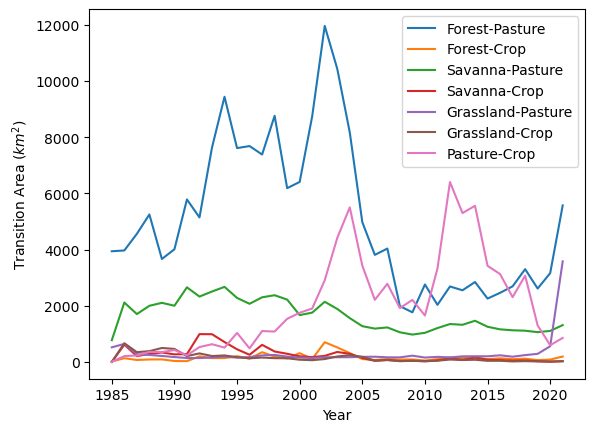

In [212]:
ax = lulc_transitions_area_df.rename(columns=rename_dict).plot()
ax.set_xlabel('Year')
ax.set_ylabel('Transition Area ($km^2$)')

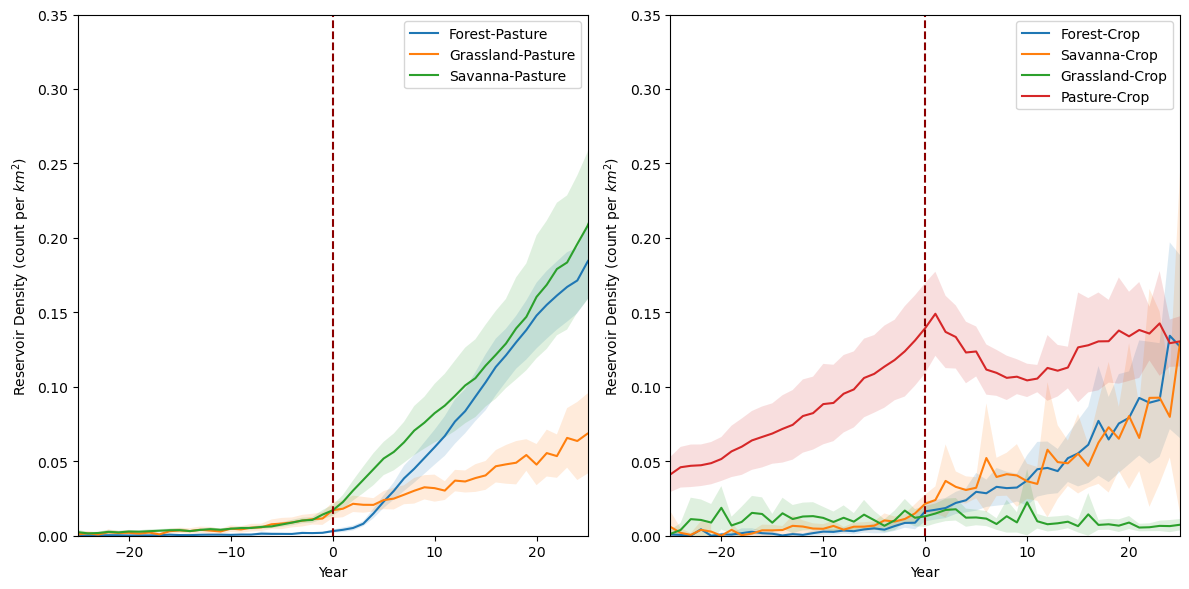

In [233]:

# Together
fig, axs = plt.subplots(1,2, figsize=(12,6))
mean_traj_toplot = mean_trajectories[['Forest-Pasture','Grassland-Pasture', 'Savanna-Pasture']]
mean_traj_toplot.plot(xlim=[-25, 25],ylim=[0,0.35], ax=axs[0])
for cover_type in mean_traj_toplot.columns:
    axs[0].fill_between(mean_traj_toplot.index,
                        bottom_traj[cover_type], top_traj[cover_type], alpha=0.15)
mean_traj_toplot = mean_trajectories[['Forest-Crop','Savanna-Crop',  'Grassland-Crop', 'Pasture-Crop']]
mean_traj_toplot.plot(xlim=[-25, 25], ylim=[0,0.35], ax=axs[1])
for cover_type in mean_traj_toplot.columns:
    axs[1].fill_between(mean_traj_toplot.index,
                        bottom_traj[cover_type], top_traj[cover_type], alpha=0.15)
for i, ax in enumerate(axs):
    ax.set_xlabel('Year')
    ax.set_ylabel('Reservoir Density (count per $km^2$)')
    ax.axvline(0,color='darkred', linestyle='--')
fig.tight_layout()
plt.show()

# Simplify: Nature, Pasture, Crop

In [ ]:
transition_regroup_dict = {
    'Natural-Pasture': ['forest-pasture', 'savanna-pasture','grassland-pasture'],
    'Natural-Crop': ['forest-crop', 'savanna-crop','grassland-crop'],
    'Pasture-Crop': ['pasture-crop'],
}

lulc_transitions_area_simple_df = pd.DataFrame({'year':lulc_transitions_area_df.index}).set_index('year')
for key, val in transition_regroup_dict.items():
    lulc_transitions_area_simple_df.loc[:, key] = lulc_transitions_area_df[val].sum(axis=1)

In [ ]:
# Group trajectories into nature, crop, pasture
regroup_dict = {
    'pasture': 'Pasture',
    'forest': 'Natural',
    'savanna': 'Natural',
    'grassland': 'Natural',
    'crop': 'Crop'
}

normalized_dfs_simple_sum = []
normalized_dfs_simple_count = []
for res_y in year_range:
    csv = './out/res_lulc_processed/res_lulc_{}.csv'.format(res_y)
    lulc_df = pd.read_csv(csv).set_index('id_in_tile').replace(regroup_dict)
    lulc_df.columns = list(lulc_df.columns[:-1].astype(int)) + [lulc_df.columns[-1]]
    transition_df = get_transition_counts(lulc_df, res_y, only_to_next_transition=True,only_permanent_transition=True,
                                          trans_area_df=lulc_transitions_area_simple_df, adjust_for_lulc_area=True)
    trans_df_count = transition_df['count'].T
    trans_df_count.index = (res_y+1) - trans_df_count.index
    trans_df_sum = transition_df['sum'].T
    trans_df_sum.index = (res_y+1) - trans_df_sum.index
    trans_df_sum.name=res_y
    trans_df_count.name=res_y
    normalized_dfs_simple_sum.append(trans_df_sum)
    normalized_dfs_simple_count.append(trans_df_count)


In [214]:
simple_full_normalized_df = pd.concat(normalized_dfs_simple_count)
simple_mean_trajectories = simple_full_normalized_df.groupby(level=0).mean()
simple_std_trajectories = simple_full_normalized_df.groupby(level=0).std()
simple_count_trajectories = simple_full_normalized_df.groupby(level=0).count()
simple_ci_low_df = simple_count_trajectories.copy()
simple_ci_high_df = simple_count_trajectories.copy()

In [217]:
for trans_type in simple_ci_low_df.columns:
    simple_ci_low_df[trans_type] = simple_full_normalized_df[trans_type].groupby(level=0).apply(calc_interval_low)
    simple_ci_high_df[trans_type] = simple_full_normalized_df[trans_type].groupby(level=0).apply(calc_interval_high)

/home/ksolvik/miniconda3/envs/resgis/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ksolvik/miniconda3/envs/resgis/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ksolvik/miniconda3/envs/resgis/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ksolvik/miniconda3/envs/resgis/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ksolvik/miniconda3/envs/resgis/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ks

/tmp/ipykernel_109180/1860373505.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Figure size 1500x500 with 0 Axes>

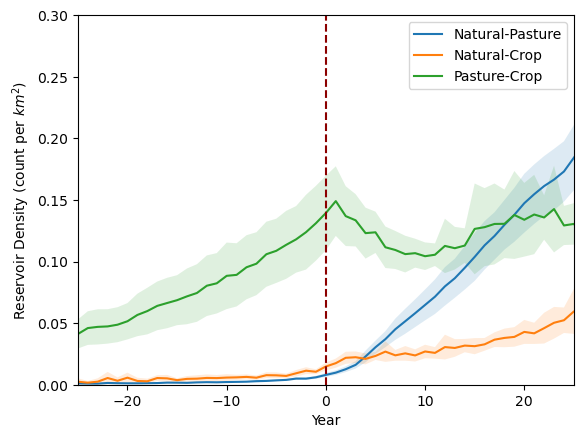

In [232]:
fig = plt.figure(figsize=(15, 5))
ax = simple_mean_trajectories.plot(xlim=[-25, 25],ylim=[0,0.30])
for cover_type in simple_mean_trajectories.columns:
    ax.fill_between(simple_mean_trajectories.index,
                    (simple_ci_low_df)[cover_type],
                    (simple_ci_high_df)[cover_type],
                    alpha=0.15)
ax.set_xlabel('Year')
ax.set_ylabel('Reservoir Density (count per $km^2$)')
ax.axvline(0,color='darkred', linestyle='--')
fig.show()

Text(0, 0.5, 'Transition Area ($km^2$)')

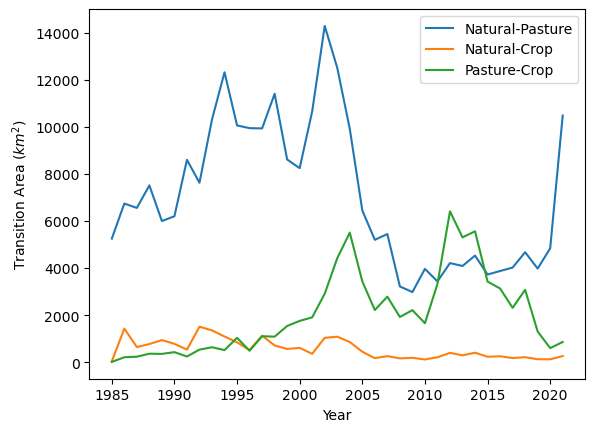

In [221]:
ax = lulc_transitions_area_simple_df.plot()
ax.set_xlabel('Year')
ax.set_ylabel('Transition Area ($km^2$)')

# General LULC fig

In [225]:
annual_lulc = pd.read_csv('./csvs/lulc_summary_mt.csv').set_index('year')
annual_lulc*= (900/1000000)
annual_lulc['Total Agricultural'] = annual_lulc['pasture'] +  annual_lulc['crop']
annual_lulc.rename(columns={'pasture': 'Pasture', 'crop': 'Crop'}, inplace=True)

In [226]:
yearof_res_list = []
for res_y in range(1985, 2022):
    yearof_res_list.append(pd.read_csv('./out/res_lulc_processed/res_lulc_{}.csv'.format(res_y))[str(res_y)])

In [227]:
yearof_counts_by_lulc = [df.value_counts() for df in yearof_res_list]
annual_res_lulc = pd.concat(yearof_counts_by_lulc, axis=1).T

In [228]:

annual_res_lulc = annual_res_lulc#.drop(columns=['other', 'forest'])
annual_res_lulc = annual_res_lulc.rename(columns={'crop': 'Crop','pasture':'Pasture'})
annual_res_lulc['Total Agricultural'] = annual_res_lulc['Crop'] + annual_res_lulc['Pasture']
annual_res_lulc.columns.name = None
annual_res_lulc_density = annual_res_lulc[['Total Agricultural', 'Pasture', 'Crop']]/annual_lulc[['Total Agricultural', 'Pasture', 'Crop']].loc[:2021].values

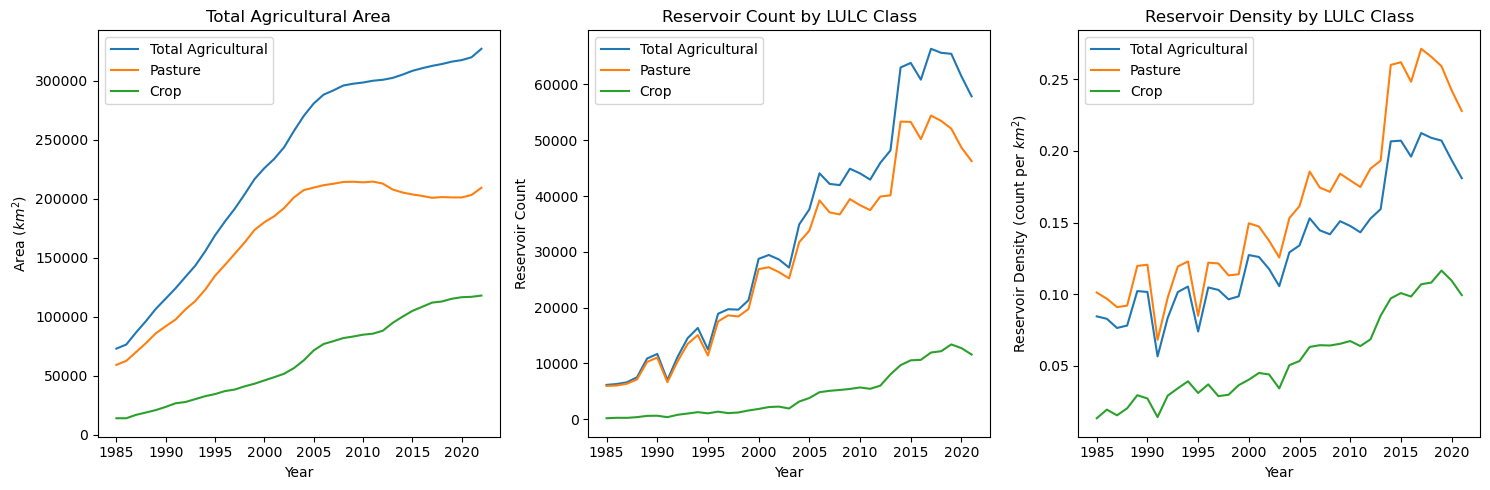

In [229]:

# Together
fig, axs = plt.subplots(1,3, figsize=(15,5))
annual_res_lulc[['Total Agricultural', 'Pasture', 'Crop']].plot(ax=axs[1])
annual_lulc[['Total Agricultural', 'Pasture', 'Crop']].plot(ax=axs[0])
annual_res_lulc_density[['Total Agricultural', 'Pasture', 'Crop']].plot(ax=axs[2])
axs[0].set_xlabel('Year')
axs[1].set_xlabel('Year')
axs[2].set_xlabel('Year')
axs[0].set_ylabel('Area ($km^2$)')
axs[1].set_ylabel('Reservoir Count')
axs[2].set_ylabel('Reservoir Density (count per $km^2$)')
axs[0].set_title('Total Agricultural Area')
axs[1].set_title('Reservoir Count by LULC Class')
axs[2].set_title('Reservoir Density by LULC Class')
fig.tight_layout()
plt.show()

# Single year plot

In [ ]:
target_year = 2000

In [ ]:

# singleyear_dfs_sum_7class = []
# singleyear_dfs_count_7class = []
# year_range = np.arange(1985, 2022)
# for res_y in year_range:
#     csv = './out/res_lulc_processed/res_lulc_{}.csv'.format(res_y)
#     lulc_df = pd.read_csv(csv).set_index('id_in_tile')
#     lulc_df.columns = list(lulc_df.columns[:-1].astype(int)) + [lulc_df.columns[-1]]
#     transition_df = get_transition_counts(lulc_df, res_y, only_to_next_transition=True, only_permanent_transition=True,
#                                           trans_area_df=lulc_transitions_area_df, adjust_for_lulc_area=True)
#     trans_df_count = transition_df['count'].T
#     trans_df_count = trans_df_count.loc[target_year]
#     trans_df_sum = transition_df['sum'].T
#     trans_df_sum = trans_df_sum.loc[target_year]
#     # trans_df_count.index = (res_y+1) - trans_df_count.index
#     # trans_df_sum = transition_df['sum'].T
#     # trans_df_sum.index = (res_y+1) - trans_df_sum.index
#     trans_df_sum.name=res_y
#     trans_df_count.name=res_y
#     singleyear_dfs_sum_7class.append(trans_df_sum)
#     singleyear_dfs_count_7class.append(trans_df_count)

In [ ]:
# Group trajectories into nature, crop, pasture
regroup_dict = {
    'pasture': 'Pasture',
    'forest': 'Natural',
    'savanna': 'Natural',
    'grassland': 'Natural',
    'crop': 'Crop'
}

singleyear_dfs_sum_3class = []
singleyear_dfs_count_3class = []
for res_y in year_range:
    csv = './out/res_lulc_processed/res_lulc_{}.csv'.format(res_y)
    lulc_df = pd.read_csv(csv).set_index('id_in_tile').replace(regroup_dict)
    lulc_df.columns = list(lulc_df.columns[:-1].astype(int)) + [lulc_df.columns[-1]]
    transition_df = get_transition_counts(lulc_df, res_y, only_to_next_transition=True,only_permanent_transition=True,
                                          trans_area_df=lulc_transitions_area_simple_df, adjust_for_lulc_area=True)
    trans_df_count = transition_df['count'].T
    trans_df_count = trans_df_count.loc[target_year]
    trans_df_sum = transition_df['sum'].T
    trans_df_sum = trans_df_sum.loc[target_year]
    trans_df_sum.name=res_y
    trans_df_count.name=res_y
    singleyear_dfs_sum_3class.append(trans_df_sum)
    singleyear_dfs_count_3class.append(trans_df_count)


singleyear_normalized_df_3class = pd.concat(singleyear_dfs_count_3class, axis=1).T


In [ ]:
fig = plt.figure(figsize=(15, 5))
ax = singleyear_normalized_df_3class.plot(ylim=[0,0.15])
ax.axvline(2000,color='darkred', linestyle='--')
ax.set_xlabel('Year')
ax.set_ylabel('Reservoir Density (count per $km^2$)')
fig.show()

# Generalized Additive Model

In [ ]:
import pygam

In [ ]:
gam_df = pd.DataFrame(columns=['years','trans_type','density'])

In [ ]:
gam_df['density'] = simple_full_normalized_df.values.flatten()

In [139]:
gam_df['trans_type'] = np.tile(simple_full_normalized_df.columns.values, simple_full_normalized_df.shape[0])
gam_df['years'] = np.repeat(simple_full_normalized_df.index.values, simple_full_normalized_df.shape[1])

In [140]:
cover_type_dict = {
    'Natural-Pasture':0,
    'Natural-Crop':1,
    'Pasture-Crop':2
}

In [141]:
gam_df['trans_type_int'] = gam_df['trans_type'].replace(cover_type_dict)

In [142]:
y = gam_df['density'].values
x = gam_df[['years','trans_type']].values

In [143]:
lams = np.random.rand(100,2)
lams = np.exp(lams)
gam = pygam.LinearGAM(pygam.s(0) + pygam.f(1)).gridsearch(x, y,lam=lams)
gam.summary()
# gam = pygam.LinearGAM(n_splines=10).gridsearch(x, y, lam=lams)

  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
  2% (2 of 100) |                        | Elapsed Time: 0:00:00 ETA:   0:00:03
  4% (4 of 100) |                        | Elapsed Time: 0:00:00 ETA:   0:00:03
  6% (6 of 100) |#                       | Elapsed Time: 0:00:00 ETA:   0:00:03
  8% (8 of 100) |#                       | Elapsed Time: 0:00:00 ETA:   0:00:03
 11% (11 of 100) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:03
 13% (13 of 100) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:03
 16% (16 of 100) |###                    | Elapsed Time: 0:00:00 ETA:   0:00:03
 18% (18 of 100) |####                   | Elapsed Time: 0:00:00 ETA:   0:00:03
 21% (21 of 100) |####                   | Elapsed Time: 0:00:00 ETA:   0:00:03
 23% (23 of 100) |#####                  | Elapsed Time: 0:00:00 ETA:   0:00:03
 25% (25 of 100) |#####                  | Elapsed Time: 0:00:00 ETA:   0:00:02
 27% (27 of 100) |######                

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     15.5741
Link Function:                     IdentityLink Log Likelihood:                               -959355.0835
Number of Samples:                         4107 AIC:                                          1918743.3151
                                                AICc:                                         1918743.4575
                                                GCV:                                                0.0021
                                                Scale:                                              0.0021
                                                Pseudo R-Squared:                                   0.5541
Feature Function                  Lam

/tmp/ipykernel_109180/635989726.py:4: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


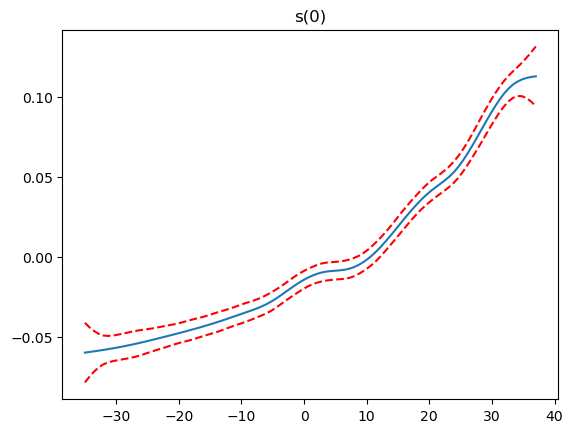

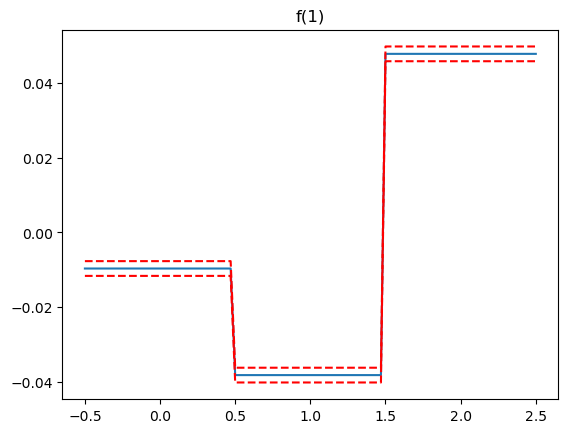

In [144]:
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(repr(term))
    plt.show()


### GAM: Fit separate models

In [152]:
help(pygam.LinearGAM().gridsearch)

Help on method gridsearch in module pygam.pygam:

gridsearch(X, y, weights=None, return_scores=False, keep_best=True, objective='auto', progress=True, **param_grids) method of pygam.pygam.LinearGAM instance
    Performs a grid search over a space of parameters for a given
    objective
    
    Warnings
    --------
    ``gridsearch`` is lazy and will not remove useless combinations
    from the search space, eg.
    
    >>> n_splines=np.arange(5,10), fit_splines=[True, False]
    
    will result in 10 loops, of which 5 are equivalent because
    ``fit_splines = False``
    
    Also, it is not recommended to search over a grid that alternates
    between known scales and unknown scales, as the scores of the
    candidate models will not be comparable.
    
    Parameters
    ----------
    X : array-like
      input data of shape (n_samples, m_features)
    
    y : array-like
      label data of shape (n_samples,)
    
    weights : array-like shape (n_samples,), optional
        s

In [157]:
for cover_type in ['Natural-Pasture','Natural-Crop','Pasture-Crop']:
    temp_df = gam_df.loc[gam_df.trans_type==cover_type]
    y = temp_df['density'].values
    x = np.array([temp_df['years'].values]).T

    lams = np.random.rand(100,1)
    lams = np.exp(lams)
    single_gam = pygam.LinearGAM(pygam.s(0)).gridsearch(x, y,lam=lams, progress=False)
    print('~'*30)
    print('~'*30)
    print('GAM results for: ', cover_type)
    print('~'*30)
    print('~'*20)
    single_gam.summary()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
GAM results for:  Natural-Pasture
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     11.5261
Link Function:                     IdentityLink Log Likelihood:                              -1120440.0584
Number of Samples:                         1369 AIC:                                          2240905.1689
                                                AICc:                                         2240905.4189
                                                GCV:                                                0.0006
                                                Scale:                                              0.0

/tmp/ipykernel_109180/2855211017.py:14: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  single_gam.summary()


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
GAM results for:  Natural-Crop
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     11.5153
Link Function:                     IdentityLink Log Likelihood:                              -3919611.5109
Number of Samples:                         1369 AIC:                                          7839248.0523
                                                AICc:                                         7839248.3019
                                                GCV:                                                0.0002
                                                Scale:                                              0.0002

/tmp/ipykernel_109180/2855211017.py:14: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  single_gam.summary()


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
GAM results for:  Pasture-Crop
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     11.5268
Link Function:                     IdentityLink Log Likelihood:                               -190771.6939
Number of Samples:                         1369 AIC:                                           381568.4414
                                                AICc:                                          381568.6915
                                                GCV:                                                0.0035
                                                Scale:                                              0.0034

/tmp/ipykernel_109180/2855211017.py:14: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  single_gam.summary()
